In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Tue Jan 16 21:42:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   52C    P0   214W / 300W |   6807MiB / 80994MiB |     64%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-10/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


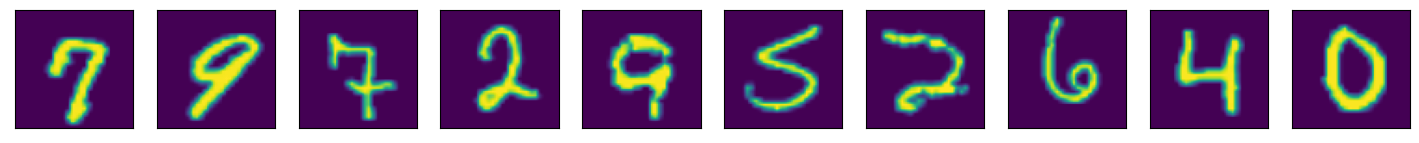

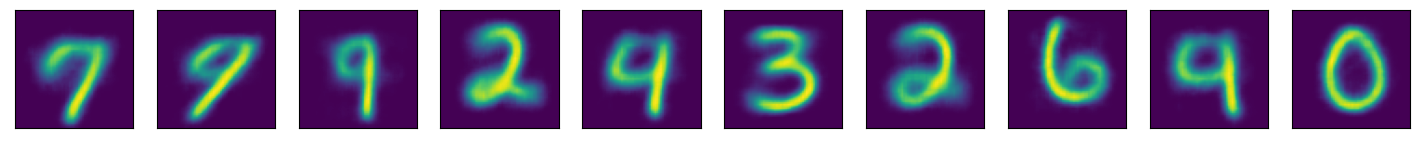

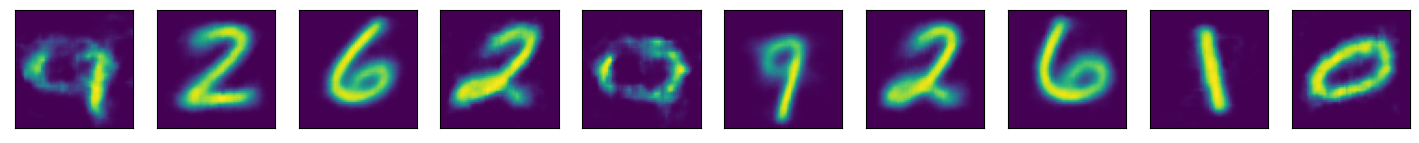

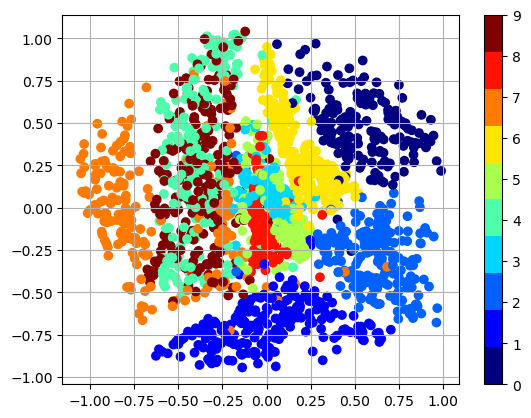

13001
swae_loss 0.0012369283533189446
recon_loss 0.1094045840203762
13002
swae_loss 0.0010617610823828727
recon_loss 0.10862683057785034
13003
swae_loss 0.001413378881989047
recon_loss 0.1013049229979515
13004
swae_loss 0.001210112846456468
recon_loss 0.10426034778356552
13005
swae_loss 0.0013540744897909463
recon_loss 0.1086544543504715
13006
swae_loss 0.0011924149584956467
recon_loss 0.11147496178746223
13007
swae_loss 0.0013716028537601233
recon_loss 0.11362042427062988
13008
swae_loss 0.0014932336518540979
recon_loss 0.10449248179793358
13009
swae_loss 0.0012266892357729376
recon_loss 0.11025311350822449
13010
swae_loss 0.0011997390247415751
recon_loss 0.11171058788895608
13011
swae_loss 0.0015004246146418155
recon_loss 0.10941455662250518
13012
swae_loss 0.0014488807879388331
recon_loss 0.11047403439879418
13013
swae_loss 0.0014680723194032907
recon_loss 0.10495373234152794
13014
swae_loss 0.0012808285013306887
recon_loss 0.10856716260313988
13015
swae_loss 0.0011165227682795376
r

swae_loss 0.0012617112777661532
recon_loss 0.11033994033932686
13122
swae_loss 0.0012839385541155933
recon_loss 0.10964877307415008
13123
swae_loss 0.0013700745766982436
recon_loss 0.10995194613933564
13124
swae_loss 0.0012497834861278534
recon_loss 0.10738401040434838
13125
swae_loss 0.0012604081130120903
recon_loss 0.10913227647542953
13126
swae_loss 0.001220870204269886
recon_loss 0.10665269494056702
13127
swae_loss 0.0013103275094181299
recon_loss 0.11590903028845786
13128
swae_loss 0.0012500929064117373
recon_loss 0.11151983588933945
13129
swae_loss 0.001462500391062349
recon_loss 0.11350138857960701
13130
swae_loss 0.0011817391030490398
recon_loss 0.10888735502958298
13131
swae_loss 0.0012108119321055711
recon_loss 0.1061710312962532
13132
swae_loss 0.0012534469482488931
recon_loss 0.11260598450899124
13133
swae_loss 0.001175135449739173
recon_loss 0.11258555725216865
13134
swae_loss 0.0012623606598936021
recon_loss 0.10434651523828506
13135
swae_loss 0.0011523808760102838
recon_

swae_loss 0.0011385476624127477
recon_loss 0.11057427749037743
13242
swae_loss 0.0011799211497418582
recon_loss 0.10715843141078948
13243
swae_loss 0.002187502454034984
recon_loss 0.11096580028533935
13244
swae_loss 0.0012675881502218545
recon_loss 0.11508506461977959
13245
swae_loss 0.0010404301807284354
recon_loss 0.10754094123840333
13246
swae_loss 0.0019144760095514356
recon_loss 0.11739122420549393
13247
swae_loss 0.0012437228753697128
recon_loss 0.1126066192984581
13248
swae_loss 0.0013137768430169672
recon_loss 0.11448649317026138
13249
swae_loss 0.0013524988666176797
recon_loss 0.10955785140395165
13250
swae_loss 0.0013510471442714333
recon_loss 0.1097104161977768
13251
swae_loss 0.0012616717896889896
recon_loss 0.10711926370859146
13252
swae_loss 0.001241622818633914
recon_loss 0.10878428444266319
13253
swae_loss 0.0013315945747308434
recon_loss 0.1149064838886261
13254
swae_loss 0.00141901143360883
recon_loss 0.11102055311203003
13255
swae_loss 0.0012466450163628906
recon_los

swae_loss 0.0012883009272627532
recon_loss 0.11889112144708633
13362
swae_loss 0.0013696632464416324
recon_loss 0.11516552940011024
13363
swae_loss 0.001124981470638886
recon_loss 0.11147858798503876
13364
swae_loss 0.0010909719800110905
recon_loss 0.10768226906657219
13365
swae_loss 0.0012153506162576378
recon_loss 0.1069151796400547
13366
swae_loss 0.0010871411941479892
recon_loss 0.10833230093121529
13367
swae_loss 0.0011329465196467936
recon_loss 0.10960164368152618
13368
swae_loss 0.0010523711971472949
recon_loss 0.1041429378092289
13369
swae_loss 0.001559337228536606
recon_loss 0.1164776936173439
13370
swae_loss 0.001256367878522724
recon_loss 0.10673097521066666
13371
swae_loss 0.0012690829520579428
recon_loss 0.10945118069648743
13372
swae_loss 0.0014242165605537593
recon_loss 0.11033937484025955
13373
swae_loss 0.0015565158100798726
recon_loss 0.11297614127397537
13374
swae_loss 0.0015169590711593627
recon_loss 0.10934871509671211
13375
swae_loss 0.001280544907785952
recon_los

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'swae_loss' in key:
                    loss = loss + data[key] * 10
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        